In [1]:
!nvidia-smi

Fri Oct 24 21:27:35 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   31C    P0    66W / 400W |      0MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pwd

/home/user02/linhdang


In [3]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt

In [4]:
class Inv3DDataset(Dataset):
    def __init__(self, root_dir, training=True, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.scan_images = []
        self.warp_images = []
        self.other_images = {
            'flat_information_delta': [], 
            'flat_text_mask': [],
            'flat_template': [],
            'warped_recon': [],
            'warped_albedo': []
        }
        
        if not training:
            self.scan_images += glob.glob(os.path.join(self.root_dir, "val", "scan", "*.png"))
        else:
            for folder in os.listdir(self.root_dir):
                if folder != "val":
                    self.scan_images += glob.glob(os.path.join(self.root_dir, folder, "scan", "*.png"))
        self.warp_images += [path.replace("scan", "warp").replace("flat", "warped") for path in self.scan_images]

        for metadata_type in self.other_images.keys():
            self.other_images[metadata_type] += [path.replace("scan", "other").replace("flat_document", metadata_type) for path in self.scan_images]

    def __len__(self):
        return len(self.scan_images)
    
    def __getitem__(self, idx):
        scan_image_path = self.scan_images[idx]
        warp_image_path = self.warp_images[idx]
        flat_information_delta_path = self.other_images['flat_information_delta'][idx]
        flat_text_mask_path = self.other_images['flat_text_mask'][idx]
        flat_template_path = self.other_images['flat_template'][idx]
        warped_recon_path = self.other_images['warped_recon'][idx]
        warped_albedo_path = self.other_images['warped_albedo'][idx]

        scan_image = Image.open(scan_image_path).convert("RGB")
        warp_image = Image.open(warp_image_path).convert("RGB")
        flat_information_delta = Image.open(flat_information_delta_path).convert("RGB")
        flat_text_mask = Image.open(flat_text_mask_path).convert("RGB")
        flat_template = Image.open(flat_template_path).convert("RGB")
        warped_recon = Image.open(warped_recon_path).convert("RGB")
        warped_albedo = Image.open(warped_albedo_path).convert("RGB")

        if self.transform:
            scan_image = self.transform(scan_image)
            warp_image = self.transform(warp_image)
            flat_information_delta = self.transform(flat_information_delta)
            flat_text_mask = self.transform(flat_text_mask)
            flat_template = self.transform(flat_template)
            warped_recon = self.transform(warped_recon)
            warped_albedo = self.transform(warped_albedo)

        return scan_image, warp_image, flat_information_delta, flat_text_mask, flat_template, warped_recon, warped_albedo

In [5]:
class DocWarpTrainDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.scan_images = glob.glob(os.path.join(self.root_dir, "docwarp", "docwarp", "Dewarping", "*", "scan", "*.png"))
        self.scan_images += glob.glob(os.path.join(self.root_dir, "docwarp", "docwarp", "Dewarping", "*", "scan", "*.jpg"))
        self.warp_images = [path.replace("scan", "warp").replace("target", "origin") for path in self.scan_images]
    
    def __len__(self):
        return len(self.scan_images)
    
    def __getitem__(self, idx):
        scan_image_path = self.scan_images[idx]
        warp_image_path = self.warp_images[idx]
        
        scan_image = Image.open(scan_image_path).convert("RGB")
        warp_image = Image.open(warp_image_path).convert("RGB")
        
        if self.transform:
            scan_image = self.transform(scan_image)
            warp_image = self.transform(warp_image)
        
        return scan_image, warp_image

In [6]:
class TrainDataset(Dataset):
    def __init__(self, root_dir, chosen_data=['inv3d', 'docwarp'], transform=None):
        
        self.root_dir = root_dir
        self.transform = transform
        self.scan_images = []
        self.warp_images = []

        if 'inv3d' in chosen_data:
            inv3d_dataset = Inv3DDataset(root_dir, True, transform)
            self.scan_images += inv3d_dataset.scan_images
            self.warp_images += inv3d_dataset.warp_images

        if 'docwarp' in chosen_data:
            docwarp_dataset = DocWarpTrainDataset(root_dir, transform)
            self.scan_images += docwarp_dataset.scan_images
            self.warp_images += docwarp_dataset.warp_images
    
    def __len__(self):
        return len(self.scan_images)
    
    def __getitem__(self, idx):
        scan_image_path = self.scan_images[idx]
        warp_image_path = self.warp_images[idx]
        
        scan_image = Image.open(scan_image_path).convert("RGB")
        warp_image = Image.open(warp_image_path).convert("RGB")
        
        if self.transform:
            scan_image = self.transform(scan_image)
            warp_image = self.transform(warp_image)
        
        return scan_image, warp_image

In [7]:
abs_path = os.path.join(os.getcwd(), 'DIR/Data')

chosen_data = ['inv3d','docwarp']

train_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

val_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

train_dataset = TrainDataset(root_dir=abs_path, chosen_data=chosen_data, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = Inv3DDataset(root_dir=abs_path, training=False, transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [8]:
print(len(train_dataset))
print(len(val_dataset))

22068
3750


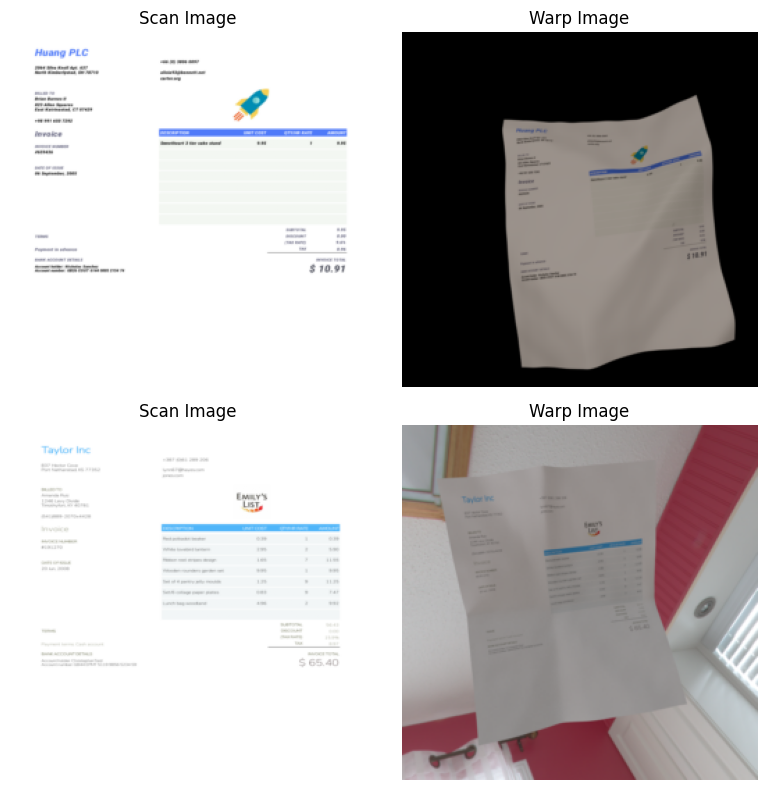

In [11]:
num_samples = 2

f, ax = plt.subplots(num_samples, 2, figsize=(8, num_samples * 4))
sample_idx = np.random.choice(len(train_dataset), num_samples, replace=False)
for i in range(num_samples):
    scan, warp = train_dataset[sample_idx[i]]
    scan = scan.squeeze().permute(1,2,0).numpy()
    warp = warp.squeeze().permute(1,2,0).numpy()
    ax[i, 0].imshow(scan)
    ax[i, 0].set_title('Scan Image')
    ax[i, 0].axis('off')
    ax[i, 1].imshow(warp)
    ax[i, 1].set_title('Warp Image')
    ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

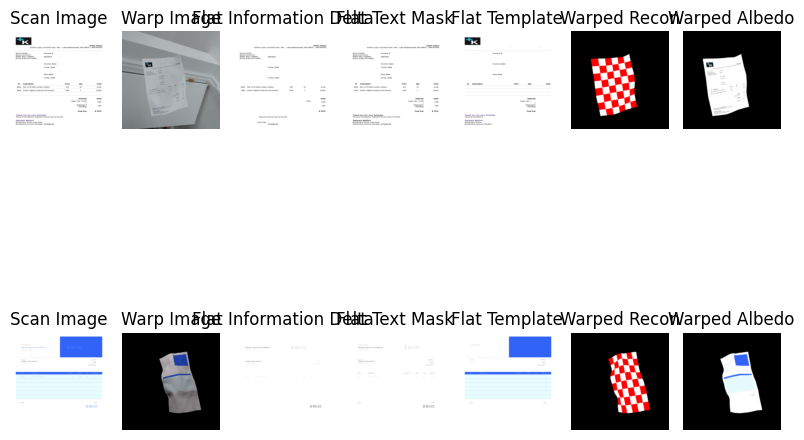

In [10]:
num_samples = 2

f, ax = plt.subplots(num_samples, 7, figsize=(8, num_samples * 4))
sample_idx = np.random.choice(len(val_dataset), num_samples, replace=False)
for i in range(num_samples):
    scan, warp, flat_information_delta, flat_text_mask, flat_template, warped_recon, warped_albedo = val_dataset[sample_idx[i]]
    scan = scan.squeeze().permute(1,2,0).numpy()
    warp = warp.squeeze().permute(1,2,0).numpy()
    flat_information_delta = flat_information_delta.squeeze().permute(1,2,0).numpy()
    flat_text_mask = flat_text_mask.squeeze().permute(1,2,0).numpy()
    flat_template = flat_template.squeeze().permute(1,2,0).numpy()
    warped_recon = warped_recon.squeeze().permute(1,2,0).numpy()
    warped_albedo = warped_albedo.squeeze().permute(1,2,0).numpy()
    ax[i, 0].imshow(scan)
    ax[i, 0].set_title('Scan Image')
    ax[i, 0].axis('off')
    ax[i, 1].imshow(warp)
    ax[i, 1].set_title('Warp Image')
    ax[i, 1].axis('off')
    ax[i, 2].imshow(flat_information_delta)
    ax[i, 2].set_title('Flat Information Delta')
    ax[i, 2].axis('off')
    ax[i, 3].imshow(flat_text_mask)
    ax[i, 3].set_title('Flat Text Mask')
    ax[i, 3].axis('off')
    ax[i, 4].imshow(flat_template)
    ax[i, 4].set_title('Flat Template')
    ax[i, 4].axis('off')
    ax[i, 5].imshow(warped_recon)
    ax[i, 5].set_title('Warped Recon')
    ax[i, 5].axis('off')
    ax[i, 6].imshow(warped_albedo)
    ax[i, 6].set_title('Warped Albedo')
    ax[i, 6].axis('off')
plt.tight_layout()
plt.show()